In [2]:
%run ../../common/import_all.py

from common.setup_notebook import set_css_style, setup_matplotlib, config_ipython

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

from common.kmeans_helpers import (retrieve_cluster_points, 
                                   compute_wcss, 
                                   compute_gap_statistic, 
                                   evaluate_gap_statistic_best_k)

config_ipython()
setup_matplotlib()
set_css_style()

dataset = '../../datasets/oldfaithful.txt'

# K-means clustering

## How it works

The $K$-means clustering algorithm needs you, the user, to choose $K$, which is the number of clusters you want to end up with. It is the fastest of the clustering methods and it always converges, though it may do to a local minimum.

<img src="../../imgs/kmeans.pdf" width="300" align="left"/> Given a set of $n$ observations, $(\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_n})$, each living in a $d$-dimensional space ($\mathbf{x} \in \mathbb{R}^d$), where $d$ are the features, the algorithms wants to partition them into $k \leq n$ clusters $\mathcal{C} = \{C_1, C_2, \ldots, C_n\}$  so to minimise the within-cluster-sum-of-squares (*WCSS*, $W$):

$$
\boxed{W = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} || \mathbf{x} - \mathbb{\mu}_i ||^2} \ ,
$$

where $\mathbb{\mu}_i$ is the mean of the points falling in cluster $C_i$ (the so-called *centroid* of the cluster), itself a vector in $\mathbb{R}^d$, each of its coordinates being the mean for that feature in the cluster.

In this horrible figure I did here, $K$ is two and the red crosses indicate the centroids.

## The standard algorithm

The standard $k$-means algorithm is [[that of Lloyds]](#lloyds) (dated 1957, was only published outside of Bell Labs in 1982).

In brief, the algorithms starts by initialising the $K$ centroids with points picked randomly from the sample. It then proceeds iteratively, until convergence, through steps called

1. *assignment*
2. *update*  

The *assignment* step consists in assigning each sample point to the cluster whose centroid is the nearest; this procedure is equivalent to partitioning the samples according to the [[Voronoi diagram]](#wikivoronoi) generated by the centroids. The voronoi diagram is a way to partition a plane in regions based on the distance to points.
The *update* step calculates the new centroids with the new cluster configuration. 

These steps are executed one after the other until the difference between new and old centroids does not exceed a chosen threshold.

## Further metrics 

On top of the *WCSS*, we can use other metrics to assess and monitor the quality and the nature for our clustering.

### Compactness

We can assess how "compact" our clustering is via summing up all the intra-cluster distances for each cluster, divided by twice the number of points in each of them:

$$
\boxed{c = \sum_{k=1}^K \frac{1}{2n_k} d_k} \ .
$$

To expand on the above, $n_k$ is the number of points in cluster $\mathcal{C}_k$ identified by index $k$, with $k \in \{1, \ldots, K\}$, and $d_k$ is the sum of distances within the cluster:

$$
d_k = \sum_{\mathbf{x} \in \mathcal{C}_k} \sum_{\mathbf{y} \in \mathcal{C}_k} || \mathbf{x} - \mathbf{y} ||^2 \ ,
$$

and it can be written as ($\mathbf{\mu}_k$ being the centroid of the cluster)

$$
2 n_k \sum_{\mathbf{x} \in C_k} || \mathbf{x} - \mathbf{\mu}_k ||^2 \ .
$$

__Proof__

By definition, we have ($\mu_k$ is the centroid of $\mathcal{C}_k$)

$$
\mathbf{\mu}_k = \frac{\sum_{\mathbf{x} \in \mathcal{C}_k} \mathbf{x}}{n_k}
$$

because each component of $\mathbf{\mu}_k$ is the mean of the corresponding components of the points in the cluster. 

The first member is (we use the fact, in the second line, that $\sum_{\mathbf{x}} 1 = n_k$):

$$
\begin{align}
\sum_{\mathbf{x}} \sum_{\mathbf{y}} (||\mathbf{x}||^2 + ||\mathbf{y}||^2 - 2 \mathbf{x} \cdot \mathbf{y}) &= 
\sum_{\mathbf{x}} \sum_{\mathbf{y}} ||\mathbf{x}||^2 + \sum_{\mathbf{x}} \sum_{\mathbf{y}} ||\mathbf{y}||^2 - 2 \sum_{\mathbf{x}} \sum_{\mathbf{y}} \mathbf{x} \cdot \mathbf{y} \\
&= n_k \sum_{\mathbf{x}} ||\mathbf{x}||^2 + n_k \sum_{\mathbf{y}} ||\mathbf{y}||^2 -2 n_k \sum_{\mathbf{x}} \mathbf{x} \cdot \mathbf{\mu}_k \\
&= 2 n_k \sum_{\mathbf{x}} ||\mathbf{x}||^2 - 2n_k^2 ||\mu_k||^2
\end{align}
$$

The second member is

$$
\begin{align}
2 n_k \big[ \sum_{\mathbf{x}} ||\mathbf{x}||^2 + \sum_{\mathbf{x}} ||\mu_k||^2 -2 \sum_{\mathbf{x}} \mathbf{x} \cdot \mathbf{\mu}_k \big] &= 2 n_k \big[ \sum_{\mathbf{x}} ||\mathbf{x}||^2 + n_k ||\mu_k||^2 - 2 n_k ||\mu_k||^2 \big] \\
&= 2 n_k \big[ \sum_{\mathbf{x}} ||\mathbf{x}||^2 - n_k ||\mu_k||^2 \big] \\
&= 2 n_k \sum_{\mathbf{x}} ||\mathbf{x}||^2 -  2 n_k^2 ||\mu_k||^2 \ ,
\end{align}
$$

so the two things are the same.

## How to choose the best $K$?

Clearly, if I choose a too large $K$, I end up with a too-fine clustering which fails in showing me similarities in the data. On the flip side, If I choose a too small $K$, I also fail in separating similar points for the reverse reason, as I'm putting too much stuff together. How should I go with choosing the $K$ that best separates my points?

There can be (at least) three ways: one rule of thumb, one heuristic and one mathematical.

### The rule of thumb

The *rule of thumb* method suggests choosing $k \sim \sqrt{n/2}$. This is a (very) hand-waving method, and gives an "approximate" clustering (it typically gives too many clusters). The justification behind it comes from the fact that it runs in linear time so it really should only be taken as an indication when wanting to reduce dataset size. 

### The elbow method

The *elbow method* is a heuristic method consisting in looking at when adding a new cluster does not model the data better any more. By plotting $W$ as a function of $k$, it should be clear where the contribution of another cluster gets minimal (the "elbow" point of the curve).

Rather than plotting $W$, the percentage of variance explained (between-cluster variance) %TODO check
can also be plotted:

$$
EV = \sum_{i=1}^{i=n} n_i  \frac{ || \mathbf{\mu}_i - \langle\mu\rangle ||^2}{k-1} \ 
$$

where $<\mu>$ is the overall mean of the data. The \textit{unexplained variance}
(within-cluster variance) %TODO check
 is

$$
UEV = \frac{WCSS}{n-k} \ ,
$$

and the percentage of explained variance is then

$$
p =\frac{EV}{UEV + EV}
$$

The elbow method is a heuristic one and prone to ambiguity.

http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means

https://bl.ocks.org/rpgove/0060ff3b656618e9136b

### The Gap Statistic method

It is a much better method presented in [[the original paper by Tibshirani, Walther, Hastie]](#gap).



The gap statistic method consists in using the logarithm of $W_k$ and compare its value to a null reference dataset. The authors define

$$
Gap(k) = \mathbb{E}[\log W^*_k] - \log W_k \ ,
$$

where the asterisk refers to the null reference dataset. It is demonstrated that the best $k$ is the smallest $k$ such that 

$$
Gap(k) \geq Gap(k+1) - s_{k+1} \ ,
$$

where $s_k$ is the simulation error calculated from the standard deviation $\sigma_k$ of B Monte Carlo replicates $\log(W^*|k)$, as 

$$
s_k = \sqrt{1 + \frac{1}{B}} \sigma_k \ ,
$$

and 

$$
\mathbb{E}[\log W^*_k] = \frac{1}{B} \sum_{b=1}^{B} \log W^*_{kb} \ ,
$$

$W^*_{kb}$ given by the clustering of $B$ reference datasets. 

The reference distribution is obtained by generating each reference feature randomly (uniformly) within the range values for that feature, that is, within the bounding box for that feature. Then the expected value is estimated by an average of $B$ copies $\log W^*_k$, each computed from a Monte Carlo sample $x^*_1, \ldots, x^*_n$, drawn from a reference distribution (x is the dataset matrix). 

Because

$$
\mathbb{E}[\log W^*_k] = \frac{1}{B} \log \Pi_b W^*_{k_b} \ ,
$$

then

$$
Gap(k) = \log \left[ \frac{(\Pi_b W^*_{k_b})^{\frac{1}{B}}}{W_k} \right]
$$

In the logarithm, at the denominator, we got the geometric mean of $W^*_k$. This last equation is saying that the gap statistics is the logarithm of the ratio of the geometric mean of $W^*_k$ to $W_k$. 

The standard deviation is

$$
\sigma_k = \sqrt{\frac{1}{B} \sum_{b=1}^B (\log W^*_{k_b} - \mathbb{E}[\log W^*_{k_b}])^2 }
$$

## Trying this!

### Let's use the "old faithful" dataset

In [3]:
# Let's read the Old Faithful dataset into a Pandas Dataframe, choosing the columns

data = pd.read_csv(dataset, delimiter=' ')[['eruptions', 'waiting']]

data.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


### Scale the data so that each column is in the same scale

In [4]:
scaled_data = scale(data)

### First, see how it looks like

It looks that 2 groups are naturally emerging from the data.

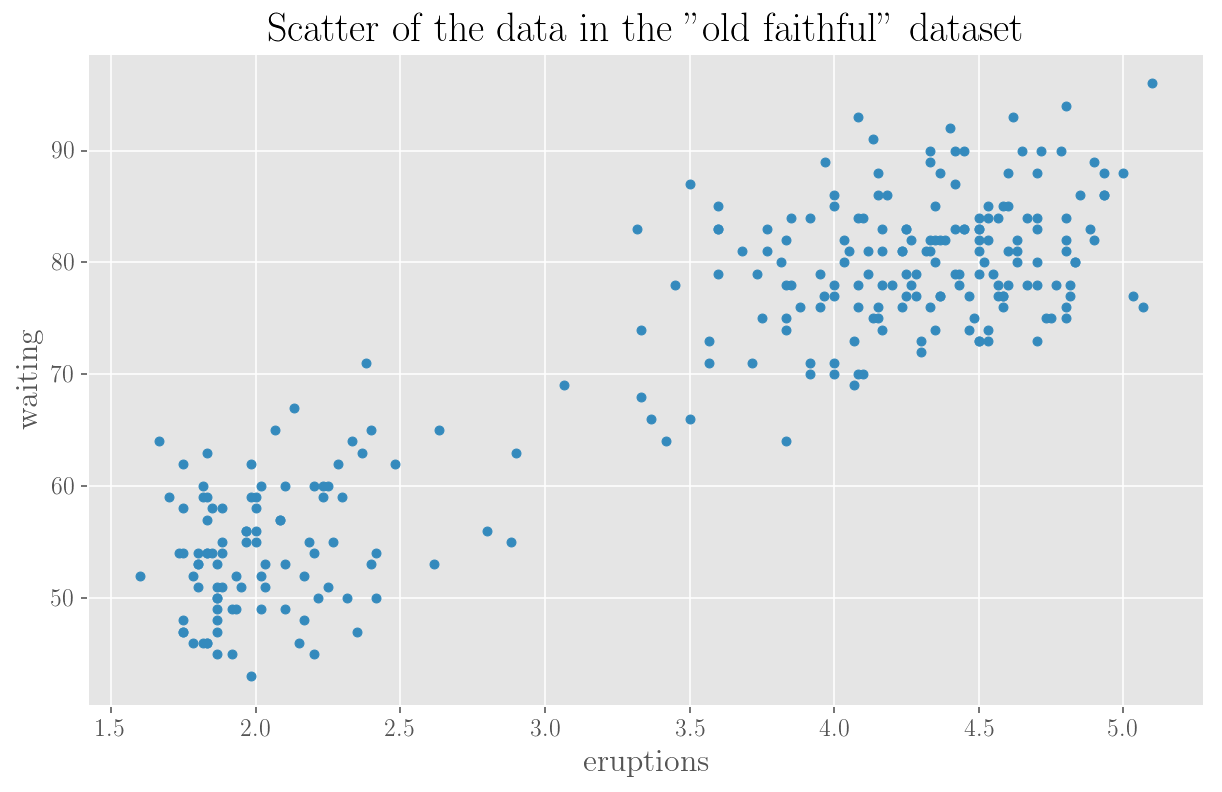

In [5]:
data.plot.scatter('eruptions', 'waiting')
plt.title('Scatter of the data in the "old faithful" dataset')
plt.show();

### What does the rule of thumb say?

In [6]:
thumb_k = np.sqrt(data.shape[0]/2)
print(' * Rule of thumb asserts optimal k =', round(thumb_k, 2))

 * Rule of thumb asserts optimal k = 11.66


### Using the elbow method

You'll see the elbow seems to appear quite soon.

k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  10
k =  11
k =  12
k =  13
k =  14
k =  15
k =  16
k =  17
k =  18
k =  19
k =  20


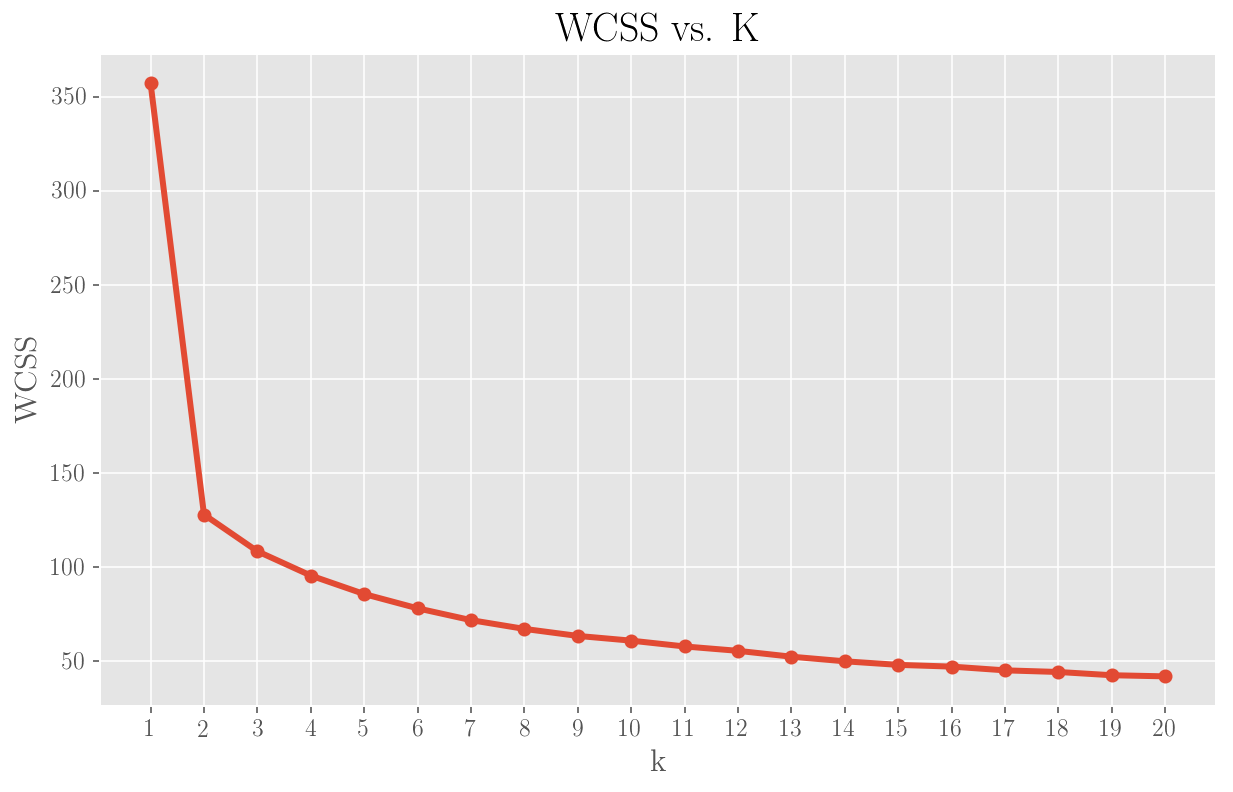

In [7]:
k_range = range(1, 21)            # range of K (decide arbitrarily how many Ks to test)
inertia_k = dict()                # inertia for each k
wcss_k = dict()                   # WCSS for each k
p_k = dict()                      # percentage of variance explained for each k

# Loop over the value of K
for k in k_range:
    print('k = ', k)
    
    # Fit the model
    fit = KMeans(n_clusters=k).fit(scaled_data)

    # Retrieve centroids for fitted model
    # A centroid is the cluster center, given as the vector of coordinates over the n_features dimensions
    # So there will be K number of n_features-dimensional centroids
    centroids = fit.cluster_centers_
    
    # Retrieve cluster labels for fitted model
    labels = fit.labels_

    # Retrieve the inertia of the fitted model
    inertia_k[k] = fit.inertia_
    
    # Compute the WCSS of the fitted model
    wcss_k[k] = compute_wcss(centroids, labels, scaled_data)
    
plt.title('WCSS vs. K')
plt.plot(k_range, list(wcss_k.values()), marker='o')
plt.xlabel('k')
plt.xticks(k_range)
plt.ylabel('WCSS')
plt.show();

### Run a clustering

In [8]:
k = 5                          # choose K

fit = KMeans(n_clusters=k).fit(scaled_data)
centroids = fit.cluster_centers_
labels = fit.labels_

labels

array([4, 3, 4, 1, 0, 1, 0, 0, 3, 0, 3, 0, 2, 3, 0, 3, 1, 0, 3, 2, 3, 3, 4,
       4, 2, 4, 3, 4, 4, 2, 4, 2, 4, 2, 4, 3, 3, 2, 1, 0, 2, 1, 0, 1, 2, 4,
       4, 3, 2, 1, 2, 0, 3, 2, 3, 2, 4, 1, 2, 2, 1, 0, 3, 2, 1, 0, 2, 2, 1,
       2, 2, 1, 2, 4, 1, 2, 1, 2, 4, 4, 4, 2, 4, 1, 4, 0, 4, 2, 3, 0, 1, 0,
       3, 2, 1, 4, 0, 4, 3, 2, 1, 0, 3, 0, 2, 3, 0, 3, 0, 4, 2, 1, 0, 2, 1,
       2, 3, 0, 1, 0, 3, 4, 2, 1, 0, 4, 3, 2, 1, 0, 3, 0, 1, 0, 3, 2, 3, 0,
       3, 4, 2, 1, 2, 2, 2, 1, 2, 3, 0, 3, 2, 4, 1, 2, 4, 4, 2, 0, 3, 0, 3,
       0, 1, 4, 4, 2, 1, 0, 3, 0, 3, 1, 2, 4, 2, 2, 2, 3, 0, 4, 3, 2, 0, 4,
       3, 2, 0, 3, 0, 1, 2, 1, 2, 0, 4, 2, 0, 2, 3, 2, 1, 2, 0, 3, 2, 3, 2,
       0, 3, 0, 1, 2, 3, 4, 4, 2, 3, 0, 3, 4, 3, 2, 3, 2, 4, 2, 4, 2, 4, 2,
       4, 3, 0, 3, 0, 3, 3, 2, 4, 1, 4, 3, 0, 1, 0, 4, 1, 2, 1, 2, 3, 0, 4,
       2, 0, 4, 4, 0, 1, 2, 2, 0, 1, 0, 3, 1, 2, 2, 3, 0, 3, 2], dtype=int32)

### Compute the gap statistic

In [9]:
k_gap = {}
for k in k_range:
    gap = compute_gap_statistic(scaled_data, k, scale_data=False)
    k_gap[k] = gap 
    
k_gapdiff = {}
for k in range(min(k_range), max(k_range)-1):
    k_gapdiff[k] = k_gap[k][0] - k_gap[k+1][0] - k_gap[k + 1][2]
        
'The best k according to the gap statistic is: ', evaluate_gap_statistic_best_k(scaled_data)

('The best k according to the gap statistic is: ', 2)

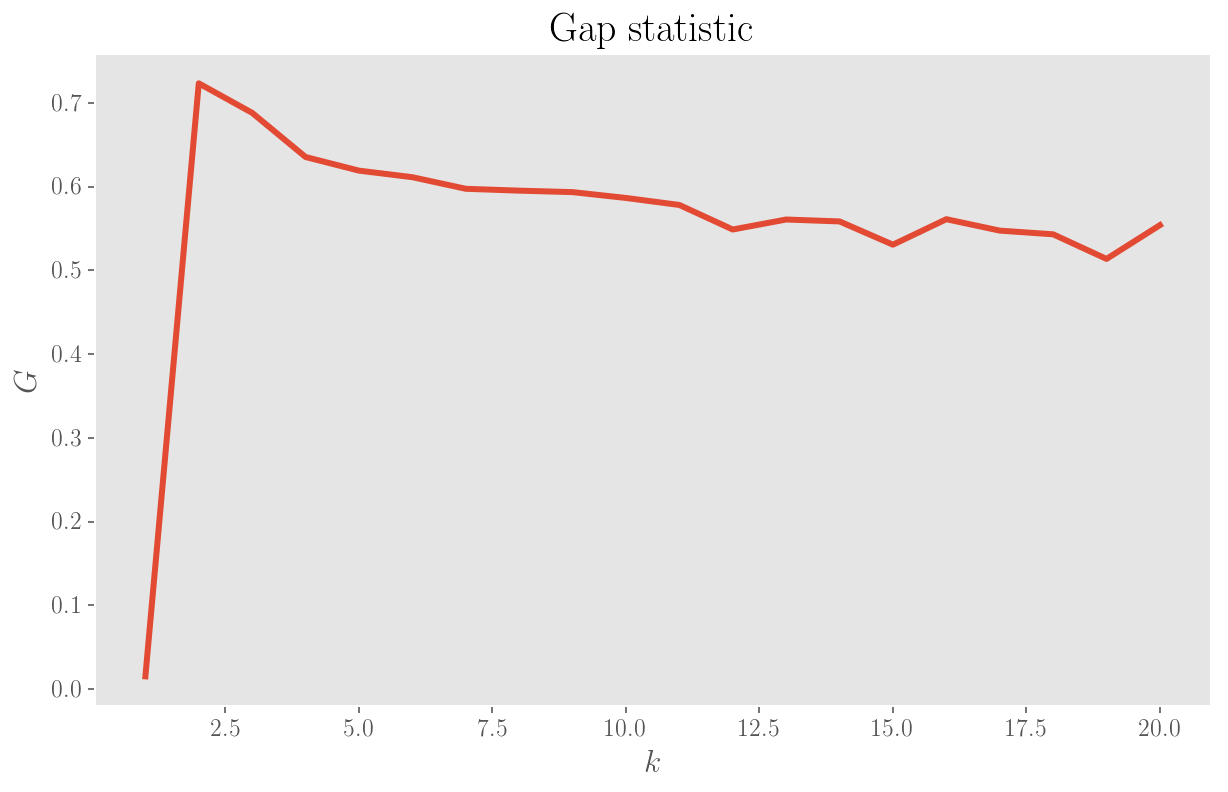

In [10]:
plt.plot(list(k_gap.keys()), [value[0] for value in k_gap.values()])
plt.title('Gap statistic')
plt.ylabel('$G$')
plt.xlabel('$k$')
plt.grid()
plt.show();

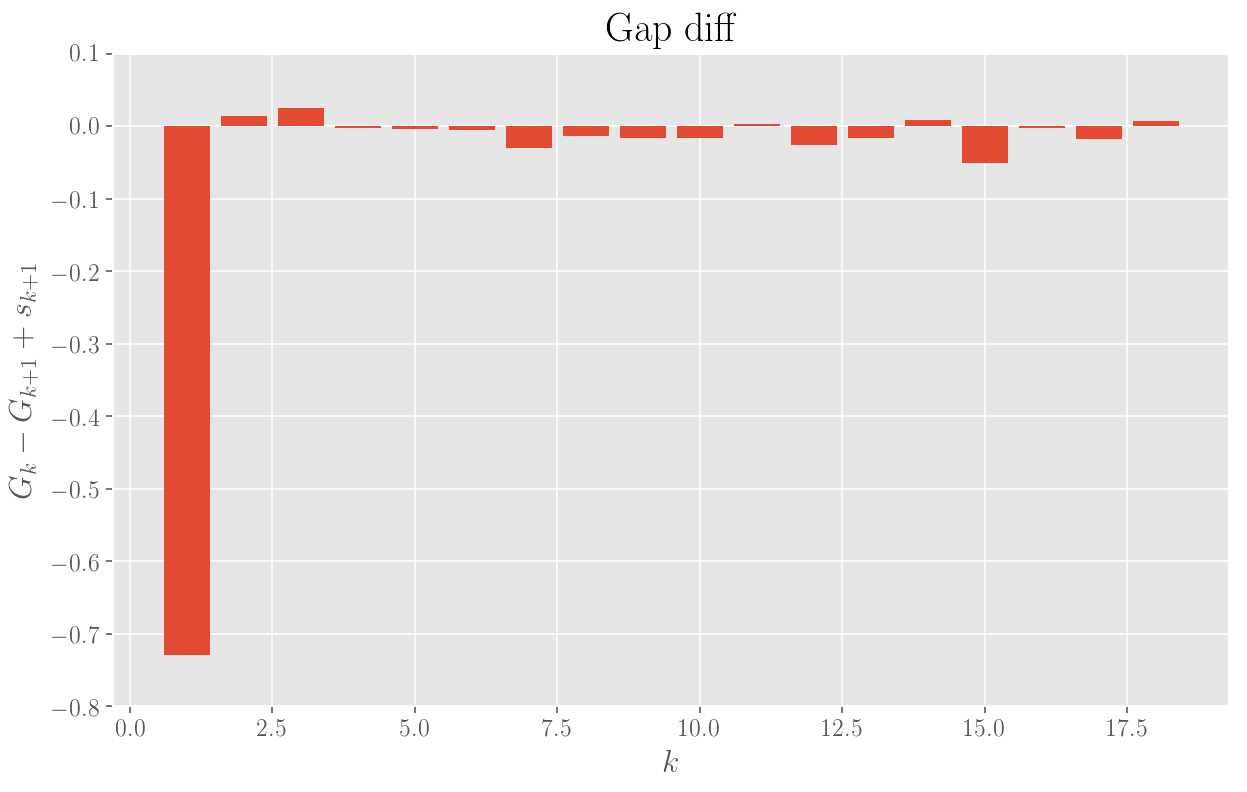

In [11]:
plt.bar(list(k_gapdiff.keys()), k_gapdiff.values())
plt.title('Gap diff')
plt.ylabel('$G_k - G_{k+1} + s_{k+1}$')
plt.xlabel('$k$')
plt.ylim(-0.8, 0.1)
plt.show();

### Scatter plot of two given features with the respective cluster colour and centroid

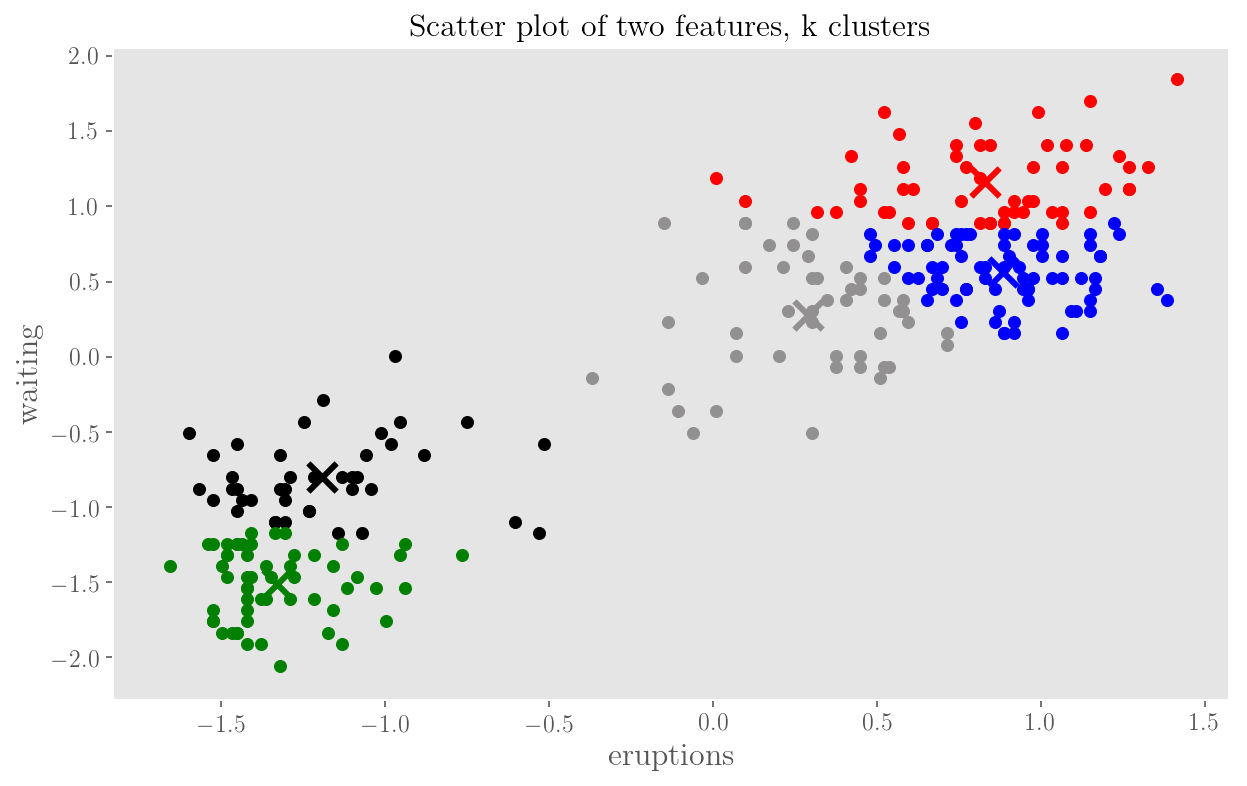

In [12]:
# Choose feature indices from the header
f1 = 1
f2 = 2

k = 5

# List of colours: if len is < k, add some
colours = {
    'red': 'r',
    'black': 'k',
    'blue': 'b',
    'green': 'g',
    'grey': '#929090',
    'pink': '#FFB6C1',
    'light_blue': '#00BFFF',
    'light_green': '#29E191'
}

plt.title('Scatter plot of two features, k clusters', fontweight='bold', fontsize=16)
plt.xlabel('eruptions')
plt.ylabel('waiting')
plt.grid()

# Note: plot displays the scaled data
for cluster_index in range(k):
    cluster_color = colours[list(colours)[cluster_index]]
    cluster_points = retrieve_cluster_points(cluster_index, labels, scaled_data)
    plt.scatter([point[f1-1] for point in cluster_points], 
                [point[f2-1] for point in cluster_points], color=cluster_color)
    plt.scatter(centroids[cluster_index,f1-1], centroids[cluster_index, f2-1], marker='x', s=200, color=cluster_color)
plt.show();

## References

1. <a name="lloyds"></a> S Lloyds, [Least squares quantization in PCM](http://www.cs.nyu.edu/~roweis/csc2515-2006/readings/lloyd57.pdf), *IEEE transactions on information theory*, 28.2, 1982
2. <a name="wikivoronoi"></a> [Wikipedia about the Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)
3. <a name="gap"></a> [This great blog on the gap statistic, with a Python implementation and examples](https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/)
4. <a name="gap"></a> Tibshirani, Walther, Hastie, [Estimating the number of clusters in a data set via the gap statistic](http://web.stanford.edu/~hastie/Papers/gap.pdf), *J R Statistic Society*, 63:2, 2001
5. http://varianceexplained.org/r/kmeans-free-lunch/